In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("../../testnum_data_0506.csv")
data.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200506,AK,372.0,23283.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,23655,23655,23655,2,1.0,0.0,962.0,1.0,963.0
1,20200506,AL,8581.0,100935.0,NaN,NaN,1158.0,NaN,442.0,NaN,...,1158.0,109516,109516,109516,1,27.0,51.0,2454.0,296.0,2750.0
2,20200506,AR,3568.0,55435.0,NaN,69.0,453.0,NaN,NaN,14.0,...,453.0,59003,59003,59003,5,5.0,0.0,4296.0,72.0,4368.0
3,20200506,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,20200506,AZ,9707.0,82030.0,NaN,754.0,1430.0,286.0,NaN,193.0,...,1430.0,91737,91737,91737,4,31.0,33.0,3075.0,402.0,3477.0


In [3]:
dat = data.loc[:,["date","state","positive"]]
dat.head()

,date,state,positive
0,20200506,AK,372.0
1,20200506,AL,8581.0
2,20200506,AR,3568.0
3,20200506,AS,0.0
4,20200506,AZ,9707.0


In [4]:
dat.date = dat.date.astype(str)
dat.date = pd.to_datetime(dat.date)
dat = dat.sort_values(by='date', ascending=True)
dat = dat.reset_index(drop=True)

In [5]:
np.sum(dat.isnull())

date         0
state        0
positive    15
dtype: int64

In [6]:
dat[dat.positive.isnull()]

,date,state,positive
599,2020-03-16,AS,NaN
655,2020-03-17,AS,NaN
709,2020-03-18,AS,NaN
766,2020-03-19,AS,NaN
822,2020-03-20,AS,NaN
879,2020-03-21,AS,NaN
934,2020-03-22,AS,NaN
989,2020-03-23,AS,NaN
1046,2020-03-24,AS,NaN
1102,2020-03-25,AS,NaN


In [7]:
# Only AS, and it's probably indeed 0, so fill in 0
dat.loc[dat.positive.isnull(),"positive"] = 0

In [8]:
dat.head()

,date,state,positive
0,2020-01-22,WA,1.0
1,2020-01-23,WA,1.0
2,2020-01-24,WA,1.0
3,2020-01-25,WA,1.0
4,2020-01-26,WA,1.0


In [9]:
states = np.unique(dat.state)

In [10]:
train_dict = {}
test_dict = {}
pred_dict = {}
mse_dict = {}
for i in states:
#     train_dict[i] = dat.loc[(dat.state == i) & (dat.date <= "2020-04-19"),["date","positive"]].reset_index(drop = True)
#     temp = dat.loc[(dat.state == i) & (dat.date > "2020-04-19"),["date","positive"]]
#     temp.index = range(train_dict[i].index[-1] + 1, train_dict[i].index[-1] + 18)
#     test_dict[i] = temp

    train_dict[i] = dat.loc[(dat.state == i) & (dat.date <= "2020-04-19"),["date","positive"]].set_index("date")
    test_dict[i] = dat.loc[(dat.state == i) & (dat.date > "2020-04-19"),["date","positive"]].set_index("date")
  
    # fit
    model = auto_arima(train_dict[i].positive, trace=False, error_action='ignore', suppress_warnings=True)
    model.fit(train_dict[i].positive)

    # pred
    forecast = model.predict(n_periods=17)
    pred_dict[i] = pd.DataFrame(forecast, index = test_dict[i].index, columns=['Prediction'])
    
    # mse
    mse_dict[i] = mean_squared_error(test_dict[i].positive, forecast)

/Users/rock/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:328: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


/Users/rock/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


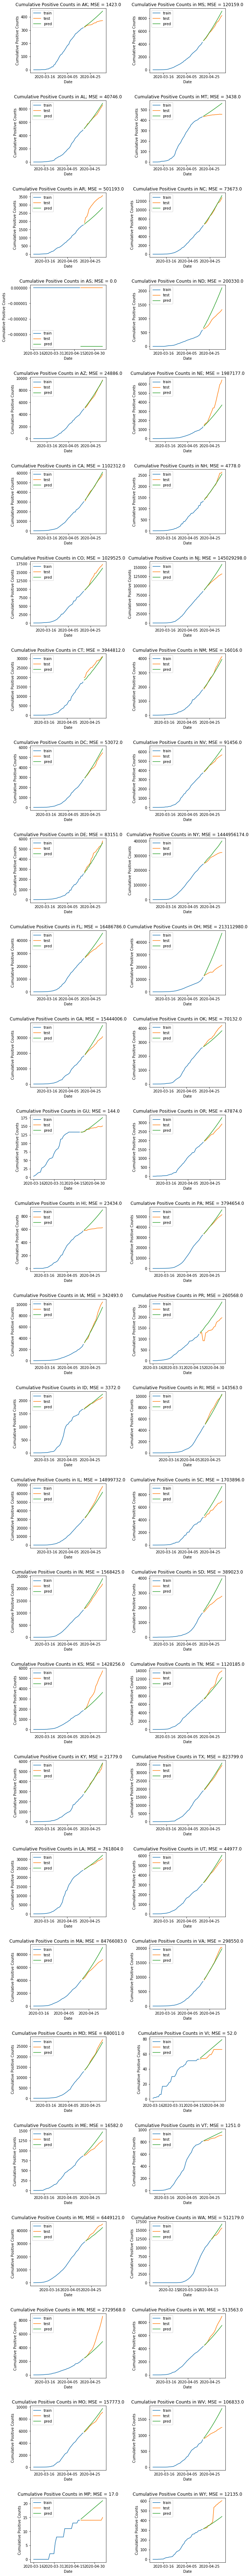

In [11]:
fig, ax = plt.subplots(28,2, figsize=(10,100))
cnt = 0
for j in range(2):
    for i in range(28):
        s = states[cnt]
        ax[i,j].plot(train_dict[s].positive, label = "train") 
        ax[i,j].plot(test_dict[s].positive, label = "test") 
        ax[i,j].plot(pred_dict[s].Prediction, label = "pred")
        ax[i,j].set(title="Cumulative Positive Counts in " + str(s) + "; MSE = " + str(round(mse_dict[s])),
                    ylabel="Cumulative Positive Counts", xlabel="Date")
        ax[i,j].legend()
        ax[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
        cnt += 1

fig.tight_layout(pad=3.0)

In [12]:
fig.savefig('../pictures/arima.png', dpi=300)

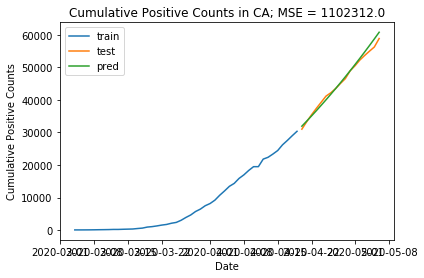

In [16]:
# try any individial state
i = "CA"
plt.plot(train_dict[i].positive, label = "train")
plt.plot(test_dict[i].positive, label = "test")
plt.plot(pred_dict[i].Prediction, label = "pred")
plt.xlabel("Date")
plt.ylabel("Cumulative Positive Counts")
plt.title("Cumulative Positive Counts in " + str(i) + "; MSE = " + str(round(mse_dict[i])))
plt.legend() 